# A quick tutorial on using Wosis

Before we start, some known issues:

* Methods - especially plotting - switch from relying on Pandas DataFrames to Metaknowledge Collections.
This is because some things are easier to accomplish with one or the other. In the future, I hope to consolidate these to use just one, not a mishmash of both. 

* Some documentation is currently missing

Suggestions on how to improve usability is appreciated, and can be made by [submitting an issue](https://github.com/ConnectedSystems/wosis/issues) with a 'usability' tag.

The cell below shows the Python version in use for this guide. Versions equal to and above should be fine.

In [1]:
import sys
print(sys.version_info)

There are two options to install Wosis for development use:

1) clone the project with `git` (the dollar sign represents the terminal prompt)

```bash
$ git clone https://github.com/ConnectedSystems/wosis.git
$ cd wosis
$ pip install git+https://github.com/ConnectedSystems/metaknowledge.git@add-collections
$ pip install git+https://github.com/titipata/wos_parser.git@master
$ pip install -e .
```

2) download, and extract, the project files from the [github repo](https://github.com/ConnectedSystems/wosis) (look for the green button on the right hand side)

```bash
$ pip install git+https://github.com/ConnectedSystems/metaknowledge.git@add-collections
$ pip install git+https://github.com/titipata/wos_parser.git@master
$ pip install -e .
```

Note the period (`.`) - yes it is important!

The first two `pip install` commands downloads and installs specific package versions that are required by Wosis.

Import packages

In [2]:
import wosis
import pandas as pd
import metaknowledge as mk
import json

Load Web of Science configuration file (this assumes the relevant file is in the same place as this notebook).

Remember not to share this file with anyone, or store it in a publicly accessible repository of any sort.

The `config.yml` file should hold your Web of Science username and password, like so:

```yaml
wos:
  user: username
  password: password
```

In [3]:
wos_config = wosis.load_config("config.yml")

Create a dictionary of search terms.

In [4]:
# dollar sign ($) is a wildcard used to match British and American spellings
# e.g. flavo$r matches both flavour and flavor
# see https://images.webofknowledge.com/images/help/WOS/hs_wildcards.html
search_terms = {
    "inclusive_kw": ("Integrated Model$ing", ),  # Keywords to include (NOTE THE TRAILING COMMA FOR SINGLE ENTRIES)
    "exclusive_kw": ("chemical", "industry", "cancer", "gene"), # Keywords to exclude
    "exclusive_jo": ('PSYCHOL*', ),  # Journals to exclude (the * tries to match anything after 'PSYCHOL')
    "subject_area": ("ENVIRONMENTAL SCIENCES", "WATER RESOURCES", "ENGINEERING ENVIRONMENTAL", "INTERDISCIPLINARY APPLICATIONS"),
}

Then build a list of queries.

The below generates a query string that we will send to Web of Science. Look at the guide here for an explanation:

http://ipscience-help.thomsonreuters.com/wosWebServicesLite/WebServiceOperationsGroup/WebServiceOperations/g2/user_query.html

In [5]:
topics = [wosis.build_query(search_terms), ]
topics

['TS=(("Integrated Model$ing") NOT ("chemical" OR "industry" OR "cancer" OR "gene")) NOT SO=("PSYCHOL*") AND WC=("ENVIRONMENTAL SCIENCES" OR "WATER RESOURCES" OR "ENGINEERING ENVIRONMENTAL" OR "INTERDISCIPLINARY APPLICATIONS")']

Now we send off the query.

Strangely, the time span of interest is not accepted as part of the WoS query, but we can specify this separately.

The `%%time` Jupyter magic command is there so we know how long this process took.

For very large amounts of records, getting the data can take a long time.

Sometimes the retrieval process fails - this could be due to high amounts of traffic to the WoS servers. Most times there's no other option other than to try again.

In [6]:
%%time
overwrite = False  # Do not overwrite previous identical search if it exists
id_to_query, query_recs = wosis.query(topics, overwrite, wos_config, time_span={'begin': '2014-01-01', 'end': '2017-12-31'})

Authenticated (SID: 5CTiZNg6WU4rUfpHZgV)


c:\userdata\takuyai\owncloud\projects\wosis\wosis\query.py:276: UserWarning: Using cached results...
  warnings.warn("Using cached results...")


Got 273 records
Wall time: 1.81 s


`id_to_query` is a dictionary that maps a result ID to the query that was sent.

`query_recs` is a dictionary that maps a result ID to the matching publication set.

So, we can write out the query_id information so that we know what data is related to which query.

This is handy for later analysis/inspection:

In [7]:
with open('tmp/example_query_id.txt', 'w') as file:
     file.write(json.dumps(id_to_query, indent=2))  # use `json.loads` to do the reverse

The retrieved dataset is cached in RIS format.

This means that you can also use data exported from a reference manager, such as EndNote, Mendeley, or Zotero, so long as it is in RIS format.

In this example the dataset is cached in a `txt` file labelled with the `query_id`.

In [8]:
# Get the ID of the query result set:
query_id = list(id_to_query)[0]

print("Query ID: ", query_id, "\nQuery String:", id_to_query[query_id], "\n")

# Load it in as a metaknowledge collection
RC = mk.RecordCollection("tmp/{}.txt".format(query_id))

# If we want to constrain the time frame later, this is how we do it
# RC = RC.yearSplit(0, 2017)

print("Corpora consists of", len(RC), "Publications")

Query ID:  72e7af00b238db01d2b12d9a3c6a4fb6 
Query String: TS=(("Integrated Model$ing") NOT ("chemical" OR "industry" OR "cancer" OR "gene")) NOT SO=("PSYCHOL*") AND WC=("ENVIRONMENTAL SCIENCES" OR "WATER RESOURCES" OR "ENGINEERING ENVIRONMENTAL" OR "INTERDISCIPLINARY APPLICATIONS") 

Corpora consists of 273 Publications


Otherwise, we can get the publication records from the query result set directly

In [9]:
RC = list(query_recs.values())[0]  # Remember, we only sent one query so it will be the first item in the dictionary
print("Corpora consists of", len(RC), "Publications")

Corpora consists of 273 Publications


Before we do any analysis, let's write out a representative data set for publication. This means stripping the generated keywords and publication abstract from the dataset as these are proprietary information owned by Web of Science.

As part of the legal usage agreement, if you make any dataset derived from Web of Science publicly available you have to specify that it came from Clarivate and when the data was retrieved. This has to be included inside any file you share.

First create a `data` directory in the location indicated (`..` means "the level above the current directory" which should be where this notebook is)

Don't forget to change the retrieval date!
(see first line starting with `fn.write` below)

(Still to come: Wosis provided method to do this for you)

In [10]:
from datetime import datetime

repset_df = pd.DataFrame(RC.forNLP(extraColumns=["AU", "SO", "DE"]))
repset_df = repset_df.drop(["keywords", "abstract"], axis=1)

assert len(repset_df.id.unique()) == len(repset_df.id), "Duplicate records found!"

repset_fn = "../data/{}.csv".format(query_id)
with open(repset_fn, 'w') as fn:
    fn.write("# Data from Clarivate Analytics' Web of Science, retrieved 1 December 2018\n")
    fn.write("# This file generated on {}\n".format(datetime.now().strftime("%Y-%m-%d %H:%M:%S")))
    repset_df.index.name = "item"
    repset_df.to_csv(fn)

Now the fun begins.

Analysis setup:

In [11]:
# Helper functions for plotting
import wosis.analysis.plotting as wos_plot

# Analysis and search functions
from wosis.analysis import (preview_matches, search_records, keyword_matches, 
                            find_pubs_by_authors, preview_matches_by_keyword, get_unique_kw_titles,
                            remove_by_journals, remove_by_title)

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# This just helps make the plots look nicer
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=2.0)

Basic analysis can be done with Pandas, but more complicated stuff is made simple by included Wosis helper functions

Count how many publications do not have a valid DOI in the Web of Science dataset...

In [12]:
corpora_df = pd.DataFrame(RC.forNLP(extraColumns=["AU", "SO", "DE", 'DOI']))

corpora_df.loc[corpora_df['DOI'] == '', 'DOI'].count()

17

... then remove them from the dataset. 

Here we're assuming that those without DOIs are unusable for our analysis.

In [13]:
corpora_df = corpora_df.loc[corpora_df['DOI'] != '', :]

Filtering by journal or title is supported in Wosis.

These methods will print out the number of articles removed for each search string.

*WARNING:* This example uses Pandas DataFrames. Future versions of Wosis will apply the changes to a Metaknowledge collection instead

In [14]:
from wosis.analysis import remove_by_journals, remove_by_title

# List of unrelated Journals - will be matched by partial string
unrelated_jo = ['PSYCHOL', 'BIOINFO']

# Think of the parameter order like "with this dataset, remove these unrelated journals"
corpora_df = remove_by_journals(corpora_df, unrelated_jo)

# Hiding keywords and abstract for tutorial (WoS-owned IP)
hide_columns = ['DE', 'abstract', 'keywords', 'DOI', 'id', 'kws']
corpora_df.loc[:, ~corpora_df.columns.isin(hide_columns)].head()  # display first 5

PSYCHOL: 0
BIOINFO: 0


,AU,SO,title,year
0,"Gustafson, David|Gutman, Alona|Leet, Whitney|D...",SUSTAINABILITY,Seven Food System Metrics of Sustainable Nutri...,2016
1,"Cheng, Su-Ting|Wiley, Michael J.",ENVIRONMENTAL MODELLING & SOFTWARE,A Reduced Parameter Stream Temperature Model (...,2016
2,"Urich, Christian|Rauch, Wolfgang",WATER RESEARCH,Exploring critical pathways for urban water ma...,2014
3,"Dias, Daniela|Tchepel, Oxana|Antunes, Antonio ...",JOURNAL OF ENVIRONMENTAL MANAGEMENT,Integrated modelling approach for the evaluati...,2016
4,"Sheykhi, Vahideh|Moore, Farid|Kavousi-Fard, Ab...",INTERNATIONAL JOURNAL OF RIVER BASIN MANAGEMENT,Integrated modelling with environmental parame...,2017


In [15]:
unrelated_TI = ['transportation networks', 'Travel Destination', 'portfolio optimization']

# Again, with this dataset remove these titles
corpora_df = remove_by_title(corpora_df, unrelated_TI)

# Hiding keywords and abstract for tutorial (WoS-owned IP)
corpora_df.loc[:, ~corpora_df.columns.isin(hide_columns)].head()  # display first 5

transportation networks: 0
Travel Destination: 0
portfolio optimization: 0


,AU,SO,title,year
0,"Gustafson, David|Gutman, Alona|Leet, Whitney|D...",SUSTAINABILITY,Seven Food System Metrics of Sustainable Nutri...,2016
1,"Cheng, Su-Ting|Wiley, Michael J.",ENVIRONMENTAL MODELLING & SOFTWARE,A Reduced Parameter Stream Temperature Model (...,2016
2,"Urich, Christian|Rauch, Wolfgang",WATER RESEARCH,Exploring critical pathways for urban water ma...,2014
3,"Dias, Daniela|Tchepel, Oxana|Antunes, Antonio ...",JOURNAL OF ENVIRONMENTAL MANAGEMENT,Integrated modelling approach for the evaluati...,2016
4,"Sheykhi, Vahideh|Moore, Farid|Kavousi-Fard, Ab...",INTERNATIONAL JOURNAL OF RIVER BASIN MANAGEMENT,Integrated modelling with environmental parame...,2017


We can then create a new Metaknowledge collection using the WOS ID

In [16]:
filtered_corpora = wosis.extract_recs(corpora_df.loc[:, 'id'], RC, name='Filtered Corpora')

Wosis has a number of convenient plotting functions. 

All of plotting functions 
* can save the resulting figure to a file by giving a file location to the `save_plot_fn` parameter.
  The figure will be saved in PNG format at 300dpi resolution.
* returns a matplotlib figure object so you can make further adjustments if desired

For example:

```python
wos_plot.plot_pub_trend(filtered_corpora, title='Publication Trend', save_plot_fn=r'C:\temp\my_figure.png')
```

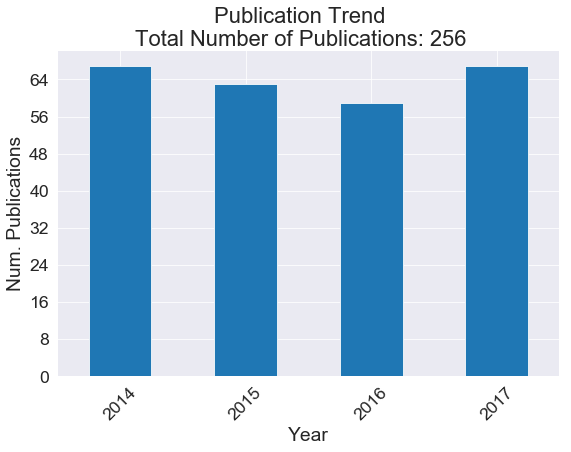

In [17]:
# Plotting out the publication trend. 
wos_plot.plot_pub_trend(filtered_corpora, title='Publication Trend', save_plot_fn=False)

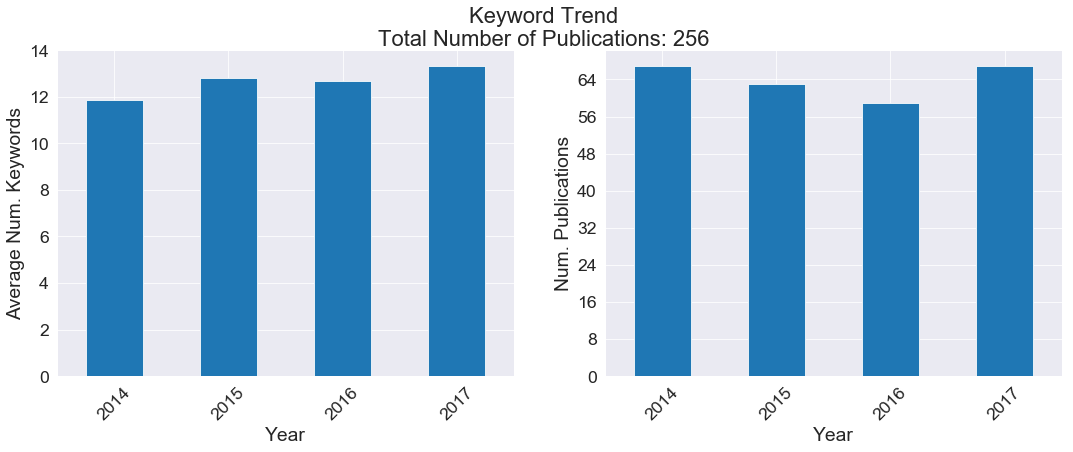

In [18]:
# Plot out the keyword trend
wos_plot.plot_kw_trend(filtered_corpora, title='Keyword Trend', save_plot_fn=False)

You can also sort the publications into specific criterias.

This matches similar words as found in the title, abstract, and keyword sections.

In [19]:
# Keyword types adapted from Zare et al. (2017)
# http://dx.doi.org/10.1016/j.jhydrol.2017.07.031

criteria = {
    'overarching': set(['uncertainty', 'adapt', 'decision support', 'management', 'gis']),
    'agri': set(['agricultur', 'farm']),
    'water': set(['hydrology', 'water', 'stream', 'aquifer']),
    'enviro': set(['environment', 'climate', 'ecology', 'ecosystem', 'biodivers']),
    'socio_economic': set(['ecosystem service', 'social', 'conflict', 'particip', 'law', 'stakehold', 'policy', 'economic'])
}

crit_matches, crit_summary = wosis.keyword_matches_by_criteria(filtered_corpora, criteria, threshold=95.0)

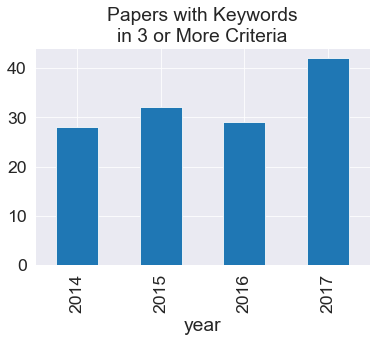

In [20]:
criteria_df = wosis.collate_keyword_criteria_matches(filtered_corpora, crit_matches)
wos_plot.plot_criteria_trend(criteria_df, threshold=3)

Remember, you can look at the documentation for anything with the question mark magic command

In [21]:
?wos_plot.plot_criteria_trend

If desired, you can search the publications for a specific keyword (or list of keywords).

Here, we look for some keywords related to the field costs - anything that is 95% similar to the given keywords is acceptable.

In [22]:
matching_records, summary = keyword_matches(filtered_corpora, ['finance', 'costs', 'capita', 'monetary'], threshold=95.0)

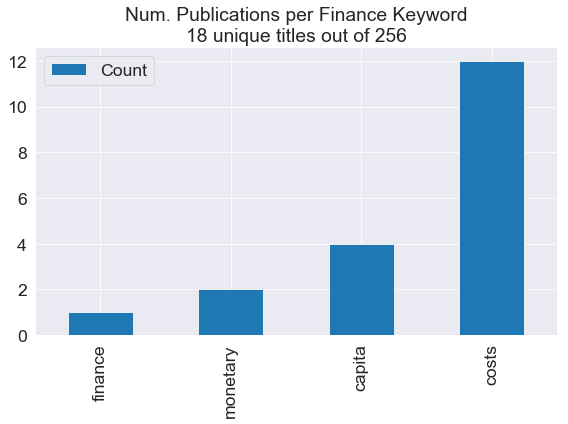

In [23]:
wos_plot.plot_pub_per_kw(matching_records, summary, filtered_corpora, kw_category='Finance')

We can then attempt to find topics of interest

*WARNING* : This is still under development and the function(s), parameter order, and return types may change

In [24]:
from wosis.analysis import find_topics, get_topic_by_id

filtered_corpora_df = pd.DataFrame(filtered_corpora.forNLP(extraColumns=["AU", "SO", "DE"]))
topic_model, trans, feature_names = find_topics(filtered_corpora_df, num_topics=10)

Topic 1: water river irrigation management supply demand basin resources use agricultural
Topic 2: model modelling models environmental modeling data management framework processes analysis
Topic 3: urban modelling infrastructure water planning drainage systems stormwater tools new
Topic 4: climate change future impacts scenarios changes vulnerability population agricultural hydrological
Topic 5: flood flash rainfall hydrological catchment runoff floods occurrence river events
Topic 6: emissions cement plant calcination sources plants dioxide carbon power emission
Topic 7: groundwater flow surface recharge aquifer model water low storage irrigation
Topic 8: energy transport modeling electricity carbon generation nexus planning fuzzy buildings
Topic 9: land use change soil erosion farm aquatic sediment changes scenarios
Topic 10: air traffic pollution quality emission pollutants emissions modelling stormwater dispersion


If the identified topics are too vague or not of interest, try increasing the number of topics. Conversely, if they are too specific, try lowering the number of topics.

Say we're interested in Topic 2. The cell below shows how to get the publications for this topic.

In [25]:
id_of_interesting_topic = 2

topic_set = get_topic_by_id(topic_model, trans, id_of_interesting_topic, filtered_corpora_df)

In [26]:
print("Number of publications in topic set:", len(topic_set))

Number of publications in topic set: 112


In [27]:
# The publication set of interest!
# Hiding keywords and abstract for tutorial (WoS-owned IP)
topic_set.loc[:, ~topic_set.columns.isin(hide_columns)].head(10)  # show first 10

,AU,SO,title,year
0,"Gustafson, David|Gutman, Alona|Leet, Whitney|D...",SUSTAINABILITY,Seven Food System Metrics of Sustainable Nutri...,2016
2,"Cheng, Su-Ting|Wiley, Michael J.",ENVIRONMENTAL MODELLING & SOFTWARE,A Reduced Parameter Stream Temperature Model (...,2016
4,"Sheykhi, Vahideh|Moore, Farid|Kavousi-Fard, Ab...",INTERNATIONAL JOURNAL OF RIVER BASIN MANAGEMENT,Integrated modelling with environmental parame...,2017
7,"Hilty, Lorenz M.|Aebischer, Bernard|Rizzoli, A...",ENVIRONMENTAL MODELLING & SOFTWARE,Modeling and evaluating the sustainability of ...,2014
9,"Xu, Jianhua|Chen, Yaning|Bai, Ling|Xu, Yiwen",HYDROLOGY AND EARTH SYSTEM SCIENCES,A hybrid model to simulate the annual runoff o...,2016
13,"Arbault, Damien|Riviere, Mylene|Rugani, Benede...",SCIENCE OF THE TOTAL ENVIRONMENT,Integrated earth system dynamic modeling for l...,2014
15,"Lechner, Alex M.|McIntyre, Neil|Witt, Katherin...",ENVIRONMENTAL MODELLING & SOFTWARE,Challenges of integrated modelling in mining r...,2017
18,"Will, Robert|Smith, Valerie|Lee, Don|Senel, Ozgur",INTERNATIONAL JOURNAL OF GREENHOUSE GAS CONTROL,"Data integration, reservoir response, and appl...",2016
20,"Yi, Shuping|Ma, Haiyi|Zheng, Chunmiao|Ren, Guo...",ENVIRONMENTAL EARTH SCIENCES,A field-scale long-term study on radionuclide ...,2014
22,"Xiao, Fei|Wong, Man Sing|Lee, Kwon Ho|Campbell...",COMPUTERS & GEOSCIENCES,Retrieval of dust storm aerosols using an inte...,2015


In [28]:
topic_recs = wosis.extract_recs(topic_set.loc[:, 'id'], RC, 'Topic of Interest')

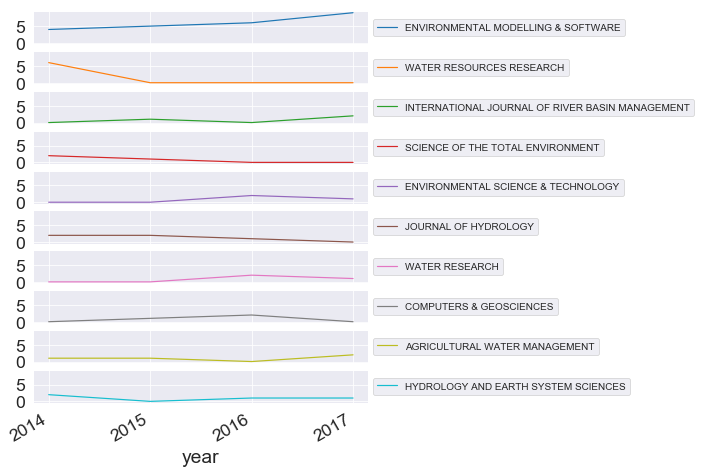

In [29]:
wos_plot.plot_journal_pub_trend(topic_recs)

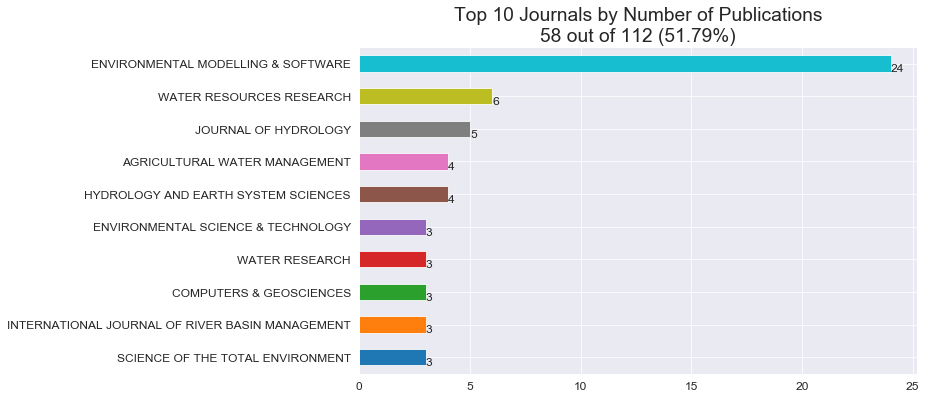

In [30]:
wos_plot.plot_pubs_per_journal(topic_recs, top_n=10, annotate=True, show_stats=True)

In [31]:
# Top 10 papers by citations
wosis.analysis.pub_citations(topic_recs)[0:10]

,Citations
Publication,
"Voinov, Alexey, 2016, Modelling with stakeholders - Next generation, ENVIRONMENTAL MODELLING & SOFTWARE, 77, 196, 505142924",26
"Laniak, Gerard F., 2013, Integrated environmental modeling: A vision and roadmap for the future, ENVIRONMENTAL MODELLING & SOFTWARE, 39, 3, 442976548",20
"Jakeman, AJ, 2003, Integrated assessment and modelling: features, principles and examples for catchment management, ENVIRONMENTAL MODELLING & SOFTWARE, 18, 491, 41702207",20
"Castronova, Anthony M., 2013, Simulating watersheds using loosely integrated model components: Evaluation of computational scaling using OpenMI, ENVIRONMENTAL MODELLING & SOFTWARE, 39, 304, 442813107",16
"Argent, RM, 2004, An overview of model integration for environmental application - components, frameworks and semantics, ENVIRONMENTAL MODELLING & SOFTWARE, 19, 219, 495524493",14
"Kelly (Letcher), Rebecca A., 2013, Selecting among five common modelling approaches for integrated environmental assessment and management, ENVIRONMENTAL MODELLING & SOFTWARE, 47, 159, 455902900",12
"Peckham, Scott D., 2013, A component-based approach to integrated modeling in the geosciences: The design of CSDMS, COMPUTERS & GEOSCIENCES, 53, 3, 450501274",12
"Arnold, JG, 1998, Large area hydrologic modeling and assessment - Part 1: Model development, JOURNAL OF THE AMERICAN WATER RESOURCES ASSOCIATION, 34, 73, 622773",12
"Granell, Carlos, 2013, Enhancing integrated environmental modelling by designing resource-oriented interfaces, ENVIRONMENTAL MODELLING & SOFTWARE, 39, 229, 442976569",11


In [32]:
# # Authors with most citations (careful interpreting this - author names are grouped by surname so it is misleading)
wosis.analysis.author_citations(topic_recs)[0:10]

,Citations
Publication,
Liu,41
Li,34
Zhang,33
Voinov,31
Wang,31
Chen,24
Wu,24
Arnold,23
Yang,21


Wosis can also help create links to the publications where possible

In [33]:
topic_df = wosis.link_to_pub(topic_recs)  # Creates a new column called 'DOI link'
topic_df.loc[:, ~topic_df.columns.isin(hide_columns)].head(10)

,AU,SO,title,year,DOI link
0,"Gustafson, David|Gutman, Alona|Leet, Whitney|D...",SUSTAINABILITY,Seven Food System Metrics of Sustainable Nutri...,2016,https://dx.doi.org/10.3390/su8030196
1,"Cheng, Su-Ting|Wiley, Michael J.",ENVIRONMENTAL MODELLING & SOFTWARE,A Reduced Parameter Stream Temperature Model (...,2016,https://dx.doi.org/10.1016/j.envsoft.2016.04.015
2,"Sheykhi, Vahideh|Moore, Farid|Kavousi-Fard, Ab...",INTERNATIONAL JOURNAL OF RIVER BASIN MANAGEMENT,Integrated modelling with environmental parame...,2017,https://dx.doi.org/10.1080/15715124.2017.1300158
3,"Hilty, Lorenz M.|Aebischer, Bernard|Rizzoli, A...",ENVIRONMENTAL MODELLING & SOFTWARE,Modeling and evaluating the sustainability of ...,2014,https://dx.doi.org/10.1016/j.envsoft.2014.04.001
4,"Xu, Jianhua|Chen, Yaning|Bai, Ling|Xu, Yiwen",HYDROLOGY AND EARTH SYSTEM SCIENCES,A hybrid model to simulate the annual runoff o...,2016,https://dx.doi.org/10.5194/hess-20-1447-2016
5,"Arbault, Damien|Riviere, Mylene|Rugani, Benede...",SCIENCE OF THE TOTAL ENVIRONMENT,Integrated earth system dynamic modeling for l...,2014,https://dx.doi.org/10.1016/j.scitotenv.2013.10...
6,"Lechner, Alex M.|McIntyre, Neil|Witt, Katherin...",ENVIRONMENTAL MODELLING & SOFTWARE,Challenges of integrated modelling in mining r...,2017,https://dx.doi.org/10.1016/j.envsoft.2017.03.020
7,"Will, Robert|Smith, Valerie|Lee, Don|Senel, Ozgur",INTERNATIONAL JOURNAL OF GREENHOUSE GAS CONTROL,"Data integration, reservoir response, and appl...",2016,https://dx.doi.org/10.1016/j.ijggc.2015.12.020
8,"Yi, Shuping|Ma, Haiyi|Zheng, Chunmiao|Ren, Guo...",ENVIRONMENTAL EARTH SCIENCES,A field-scale long-term study on radionuclide ...,2014,https://dx.doi.org/10.1007/s12665-014-3343-1
9,"Xiao, Fei|Wong, Man Sing|Lee, Kwon Ho|Campbell...",COMPUTERS & GEOSCIENCES,Retrieval of dust storm aerosols using an inte...,2015,https://dx.doi.org/10.1016/j.cageo.2015.02.016


Other analysis can easily be accomplished with Pandas